In [1]:
import os
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import uproot

from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')

In [2]:
DATASET = 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root'

In [3]:
templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.2, 20.1, 25, 29.9, 34.9, 39.8]
badchannels = [7, 10, 11, 18, 19, 37]
runlist = [
           [1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936], # -10
           [1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926], # -5
           [1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916], # 0
           [1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906], # 5   
           [1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896], # 10 
           [1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886], # 15
           [1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876], # 20
           [1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836], # 25
           [1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846], # 30
           [1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856], # 35
           [1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866] # 40  
          ]        
        
bias = np.array([
                 [51.1, 51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
                 [51.4, 51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
                 [51.7, 52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [52.5, 53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.3, 53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

6.600127 51.562405 0.1280027
6.822203 47.4116 0.14389312
7.301916 49.52976 0.14742483
3.5200717 51.379757 0.06851087
6.0483794 49.473476 0.12225499
6.3039465 50.24935 0.1254533
5.7043715 47.03185 0.12128741
6.8988347 51.282658 0.13452569
6.2176867 48.54632 0.1280774
6.3312216 47.927628 0.13209963
5.9595065 48.268078 0.12346683


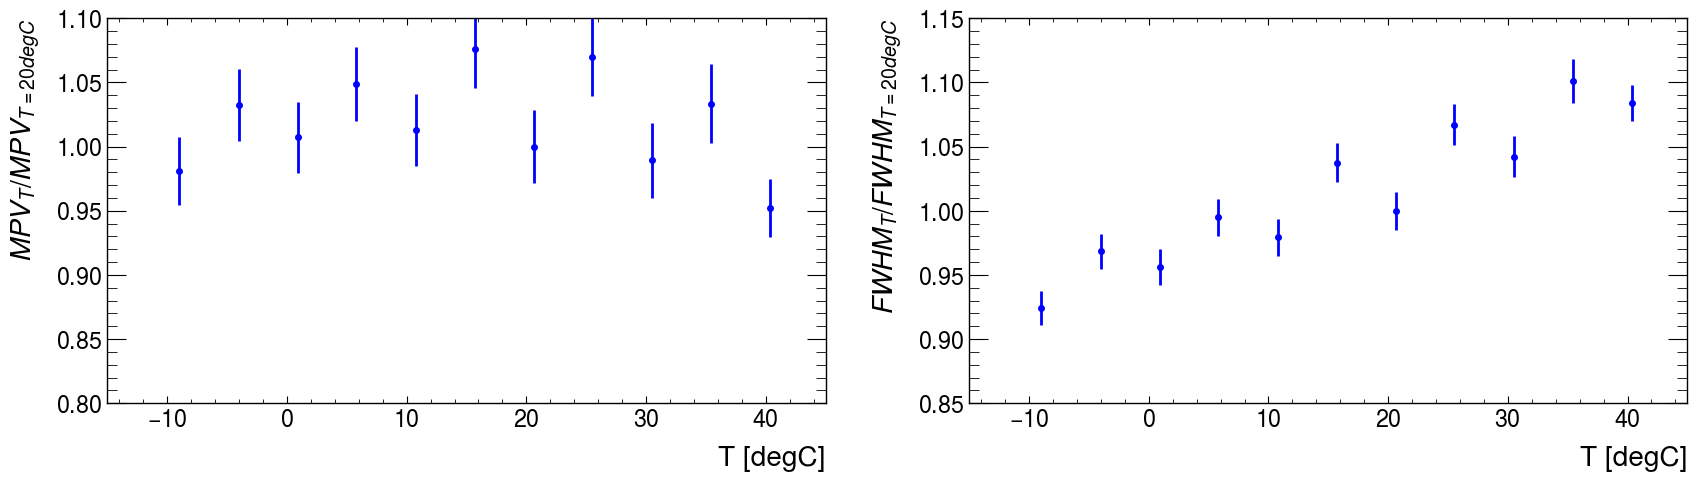

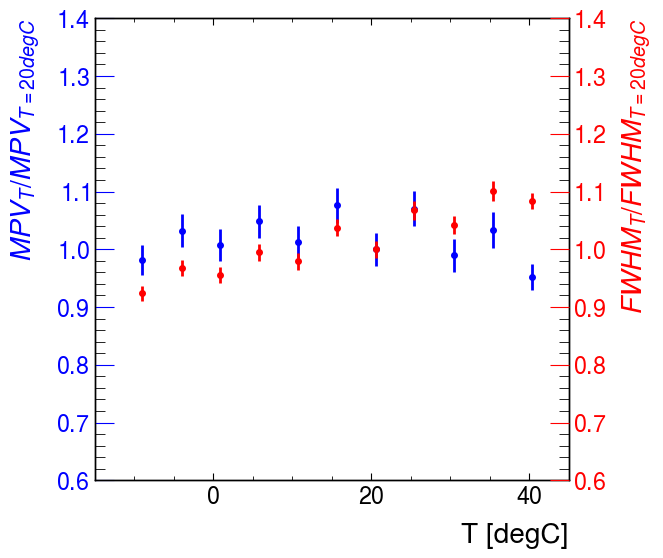

In [4]:
templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.2, 20.1, 25.0, 29.9, 34.9, 39.8]
runlist = [1932, 1922, 1911, 1901, 1890, 1880, 1869, 1829, 1838, 1848, 1857] 
bias = [53.6, 53.9, 53.7, 53.9, 53.7, 54.0, 53.7, 54.0, 53.8, 54.0, 53.8]
badchannels = [7, 10, 11, 18, 19, 37, 38]

filepath_sidet = "/exp/mu2e/data/users/thoroho/sidet/"
filelist_sidet = ["{}{}{}".format(filepath_sidet, i, ":runSummary") for i in os.listdir(filepath_sidet)]

for filename in filelist_sidet:
    if '1869' in filename:
        filenameT0 = filename
        
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True)

MPV = []
MPVsigma = []
FWHM = []
FWHMsigma = []
temp = []
        
for idx, filename in enumerate(filelist_sidet):
    FWHMT = []
    FWHMRef = []
    PET = []
    PERef = []
    temps = []
    chans = []
    histbins = np.linspace(0.25, 2, 30)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB",
                                report=False, library='ak'):
            with uproot.open(filenameT0) as fileT0:
                for arT0 in fileT0.iterate(step_size="100MB",
                                           report=False, library='ak'):
                    for chan in range(16,64):
                        if chan in badchannels:
                            continue
                        if ar['PEsTemperatureCorrected'][0,0,chan] > 0 and ar['signals'][0,0,chan] > 4000 and arT0['PEsTemperatureCorrected'][0,0,chan] > 0 and arT0['signals'][0,0,chan] > 4000:
                            PET.append(ar['PEsTemperatureCorrected'][0,0,chan])
                            PERef.append(arT0['PEsTemperatureCorrected'][0,0,chan])
                            FWHMT.append(ar['FWHMsTemperatureCorrected'][0,0,chan])
                            FWHMRef.append(arT0['FWHMsTemperatureCorrected'][0,0,chan])
                            temps.append(ar['meanTemperatures'][0,0,chan])
                            chans.append(chan)
     
    MPV.append(np.mean(PET)/np.mean(PERef))
    print(np.std(PET), np.mean(PET), np.std(PET)/np.mean(PET))
    MPVsigma.append((np.mean(PET)/np.mean(PERef))*np.sqrt((np.std(PET)/np.mean(PET))**2 + (np.std(PERef)/np.mean(PERef))**2)/np.sqrt(len(PET)))
    FWHM.append(np.mean(FWHMT)/np.mean(FWHMRef))
    FWHMsigma.append((np.mean(FWHMT)/np.mean(FWHMRef))*np.sqrt((np.std(FWHMT)/np.mean(FWHMT))**2 + (np.std(FWHMRef)/np.mean(FWHMRef))**2)/np.sqrt(len(FWHMT)))
    temp.append(np.mean(temps))
ax0.errorbar(temp, MPV, yerr=MPVsigma, color='b',fmt='.')
ax0.set_ylim((0.8, 1.1))
ax0.set_xlim((-15,45))
ax0.set_xlabel('T [degC]')
ax0.set_ylabel('$MPV_{T}/MPV_{T=20degC}$')

ax1.errorbar(temp, FWHM, yerr=FWHMsigma, color='b',fmt='.')
ax1.set_ylim((0.85, 1.15))
ax1.set_xlim((-15,45))
ax1.set_xlabel('T [degC]')
ax1.set_ylabel('$FWHM_{T}/FWHM_{T=20degC}$')

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.show()


fig, ax0, = plt.subplots(1, 1, sharex=True)
ax1 = ax0.twinx()

ax0.errorbar(temp, MPV, yerr=MPVsigma, color='b',fmt='.')
ax0.set_ylim((0.6, 1.4))
ax0.set_xlim((-15,45))
ax0.set_xlabel('T [degC]')
ax0.set_ylabel('$MPV_{T}/MPV_{T=20degC}$')
ax0.yaxis.label.set_color('b')
ax0.tick_params(axis='y', colors='b')

ax1.errorbar(temp, FWHM, yerr=FWHMsigma, color='r',fmt='.')
ax1.set_ylim((0.6, 1.4))
ax1.set_xlim((-15,45))
ax1.set_xlabel('T [degC]')
ax1.set_ylabel('$FWHM_{T}/FWHM_{T=20degC}$')
ax1.yaxis.label.set_color('r')
ax1.tick_params(axis='y', colors='r')

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()

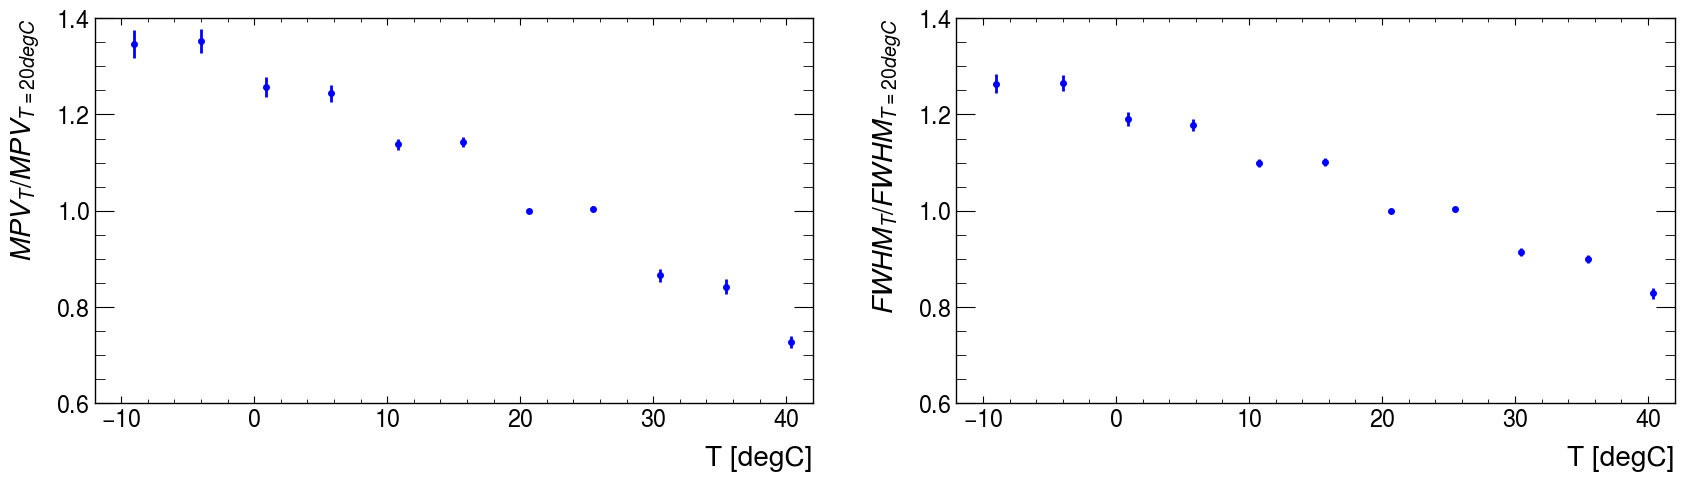

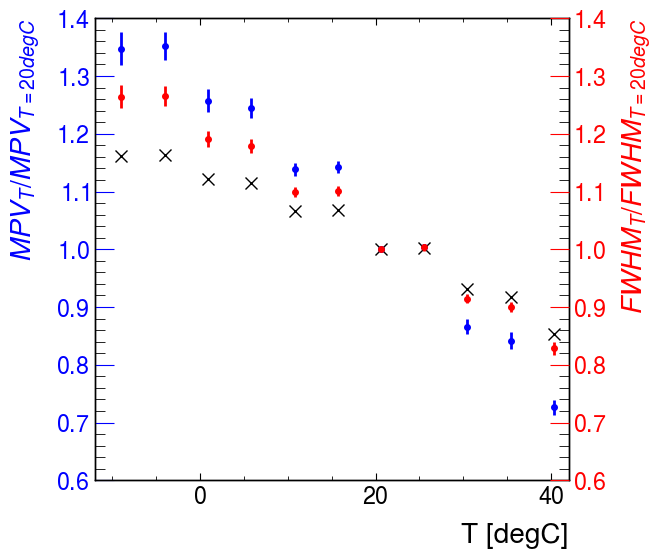

In [5]:
filepath_sidet = "/exp/mu2e/data/users/thoroho/sidet/"
filelist_sidet = ["{}{}{}".format(filepath_sidet, i, ":runSummary") for i in os.listdir(filepath_sidet)]

for filename in filelist_sidet:
    if '1869' in filename:
        filenameT0 = filename
        
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True)

MPV = []
MPVsigma = []
sqrtMPV = []
sqrtMPVsigma = []
FWHM = []
FWHMsigma = []
temp = []
        
for idx, filename in enumerate(filelist_sidet):
    FWHMratio = []
    PEratio = []
    temps = []
    chans = []
    histbins = np.linspace(0.25, 2, 30)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB",
                                report=False, library='ak'):
            with uproot.open(filenameT0) as fileT0:
                for arT0 in fileT0.iterate(step_size="100MB",
                                           report=False, library='ak'):
                    for chan in range(16,64):
                        if chan in badchannels:
                            continue
                        if ar['PEsTemperatureCorrected'][0,0,chan] > 0 and ar['signals'][0,0,chan] > 4000 and arT0['PEsTemperatureCorrected'][0,0,chan] > 0 and arT0['signals'][0,0,chan] > 4000:
                            PEratio.append(ar['PEs'][0,0,chan]/arT0['PEs'][0,0,chan])
                            FWHMratio.append(ar['FWHMs'][0,0,chan]/arT0['FWHMs'][0,0,chan])
                            temps.append(ar['meanTemperatures'][0,0,chan])
                            chans.append(chan)
    MPV.append(np.mean(PEratio))
    MPVsigma.append(np.std(PEratio))
    sqrtMPV.append(np.sqrt(np.mean(PEratio)))
    sqrtMPVsigma.append(0)
    FWHM.append(np.mean(FWHMratio))
    FWHMsigma.append(np.std(FWHMratio))
    temp.append(np.mean(temps))
ax0.errorbar(temp, MPV, yerr=MPVsigma, color='b',fmt='.')
ax0.set_ylim((0.6, 1.4))
ax0.set_xlim((-12,42))
ax0.set_xlabel('T [degC]')
ax0.set_ylabel('$MPV_{T}/MPV_{T=20degC}$')

ax1.errorbar(temp, FWHM, yerr=FWHMsigma, color='b',fmt='.')
ax1.set_ylim((0.6, 1.4))
ax1.set_xlim((-12,42))
ax1.set_xlabel('T [degC]')
ax1.set_ylabel('$FWHM_{T}/FWHM_{T=20degC}$')

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.show()


fig, ax0, = plt.subplots(1, 1, sharex=True)
ax1 = ax0.twinx()

ax0.errorbar(temp, MPV, yerr=MPVsigma, color='b',fmt='.')
ax0.errorbar(temp, sqrtMPV, yerr=sqrtMPVsigma, color='k', fmt='x')
ax0.set_ylim((0.6, 1.4))
ax0.set_xlim((-12,42))
ax0.set_xlabel('T [degC]')
ax0.set_ylabel('$MPV_{T}/MPV_{T=20degC}$')
ax0.yaxis.label.set_color('b')
ax0.tick_params(axis='y', colors='b')

ax1.errorbar(temp, FWHM, yerr=FWHMsigma, color='r',fmt='.')
ax1.set_ylim((0.6, 1.4))
ax1.set_xlim((-12,42))
ax1.set_xlabel('T [degC]')
ax1.set_ylabel('$FWHM_{T}/FWHM_{T=20degC}$')
ax1.yaxis.label.set_color('r')
ax1.tick_params(axis='y', colors='r')

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()

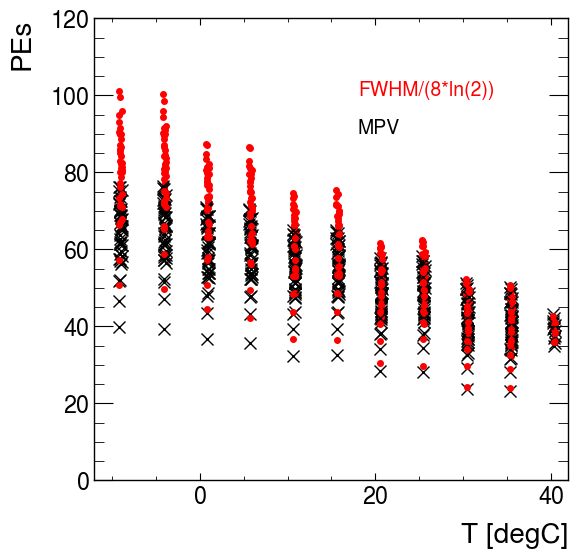

In [6]:
fig, ax0 = plt.subplots(1, 1)

for idx, filename in enumerate(filelist_sidet):
    FWHMratio = []
    PEratio = []
    temps = []
    chans = []
    histbins = np.linspace(0.25, 2, 30)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB",
                                report=False, library='ak'):
            with uproot.open(filenameT0) as fileT0:
                for arT0 in fileT0.iterate(step_size="100MB",
                                           report=False, library='ak'):
                    for chan in range(16,64):
                        if chan in badchannels:
                            continue
                        if ar['PEsTemperatureCorrected'][0,0,chan] > 0 and ar['signals'][0,0,chan] > 4000 and arT0['PEsTemperatureCorrected'][0,0,chan] > 0 and arT0['signals'][0,0,chan] > 4000:
                            ax0.errorbar(ar['meanTemperatures'][0,0,chan], ar['PEs'][0,0,chan], yerr=0, color='k', fmt='x',label='MPV')
                            ax0.errorbar(ar['meanTemperatures'][0,0,chan], ((ar['FWHMs'][0,0,chan])**2)/(8*np.log(2)), yerr=0, color='r',fmt='.',label='FWHM/(8*ln(2))')
                            
#ax0.set_ylim((0.6, 1.4))
ax0.set_xlim((-12,42))
ax0.set_xlabel('T [degC]')
ax0.set_ylabel('PEs')

ax0.text(18, 100, 'FWHM/(8*ln(2))', color='r')
ax0.text(18, 90, 'MPV', color='k')

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()

In [7]:
Vbd_channels = [[49.575384,49.472901,49.588503,49.630253,49.542179,49.58175,49.613718,49.599103,49.593545,49.558326,49.552705,49.630657,49.515598,49.621699,49.700481,49.52309,48.987479,49.215767,49.251946,49.225899,49.445092,49.60279,49.5,49.472481,49.150426,49.210846,49.207698,49.274996,49.271782,49.319784,49.27073,49.362042,49.328357,49.4354,49.336292,49.356307,49.507554,49.599953,49.656299,49.484734,49.531973,49.629948,49.549312,49.565075,49.553225,49.47186,49.591478,49.538331],
                [49.846738,49.743306,49.879741,49.872779,49.825795,49.869762,49.914682,49.830432,49.850287,49.785592,49.835635,49.843561,49.781154,49.8414,49.918604,49.758274,49.271987,49.481912,49.554405,49.605596,49.775972,49.907243,49.8,49.772246,49.391628,49.517486,49.448181,49.5554,49.439221,49.574571,49.537953,49.586347,49.65872,49.698283,49.64498,49.618066,49.806236,49.877516,49.929824,49.789165,49.817905,49.92155,49.833678,49.846833,49.827032,49.736483,49.888183,49.800832],
                [50.130191,50.01474,50.1628,50.157495,50.100775,50.076683,50.191743,50.105117,50.10978,50.074888,50.150608,50.141042,50.095453,50.123728,50.215237,50.093651,49.549318,49.760861,49.849724,49.850561,50.050031,50.141125,50.151413,50.051646,49.705968,49.784883,49.749762,49.890684,49.80453,49.851719,49.803467,49.893787,49.946316,49.972664,49.918784,49.850637,50.130631,50.133024,50.198089,50.04312,50.115658,50.221456,50.6694,50.134677,50.138388,50.053935,50.131857,50.167737],
                [50.427409,50.303211,50.434589,50.448599,50.360965,50.365312,50.450053,50.408495,50.398507,50.370567,50.410565,50.437657,50.39598,50.419535,50.525047,50.350929,49.879296,50.061111,50.110939,50.136261,50.339179,50.456181,50.390319,50.375606,49.981722,50.068251,50.006981,50.142362,50.082625,50.130829,50.108908,50.157961,50.231832,50.216067,50.243864,50.168915,50.429716,50.473789,50.571202,50.316465,50.362446,50.489801,50.4,50.408172,50.398543,50.327977,50.395203,50.39035],
                [50.659833,50.548065,50.686824,50.709245,50.628321,50.625446,50.70655,50.645543,50.616417,50.583156,50.614371,50.645954,50.607312,50.651621,50.729583,50.582791,50.129086,50.30914,50.385218,50.409589,50.574409,50.673329,50.642322,50.593453,50.220631,50.301719,50.250448,50.376846,50.29844,50.377816,50.343815,50.395829,50.506248,50.485907,50.478618,50.438026,50.682847,50.698501,50.786557,50.593085,50.614502,50.727927,50.659529,50.669847,50.636464,50.575797,50.641276,50.653092],
                [50.934858,50.804232,50.974604,50.972318,50.883347,50.897937,50.96903,50.917313,50.90789,50.889899,50.933534,50.950533,50.929225,50.938799,51.026934,50.904258,50.380855,50.589586,50.672718,50.700144,50.850755,50.972043,50.919502,50.87842,50.54656,50.602679,50.549394,50.674876,50.603916,50.650003,50.633038,50.693838,50.765146,50.770656,50.764511,50.720087,50.948905,50.972299,51.038677,50.865275,50.898708,51.02061,50.780148,50.948666,50.9528,50.871969,50.948593,50.966036],
                [51.227196,51.101283,51.236962,51.253418,51.174577,51.189449,51.239907,51.183707,51.167867,51.152962,51.20465,51.220259,51.174934,51.21011,51.287184,51.160081,50.668907,50.872169,50.942979,50.980225,51.143112,51.257695,51.171067,51.159968,50.826113,50.872792,50.839006,50.94522,50.901585,50.940685,50.898092,50.964851,51.067904,51.053644,51.03201,50.985473,51.230426,51.248663,51.350213,51.143326,51.192426,51.301682,51.232903,51.236412,51.23493,51.16527,51.22408,51.245731],
                [51.46881,51.355471,51.49014,51.497946,51.43384,51.43524,51.490819,51.457973,51.446833,51.42301,51.458186,51.479195,51.45249,51.470759,51.547212,51.413766,50.929225,51.136114,51.201112,51.253773,51.40066,51.529985,51.470194,51.418445,51.049757,51.099098,51.080281,51.185046,51.037245,51.164939,51.146317,51.217304,51.338074,51.309342,51.303092,51.265427,51.523964,51.517339,51.59144,51.413641,51.425851,51.531582,51.442306,51.473773,51.46739,51.386173,51.457803,51.493464],
                [51.758005,51.635435,51.767086,51.780884,51.707142,51.715718,51.762424,51.7259,51.713004,51.678707,51.720869,51.742343,51.7113,51.7477,51.802103,51.688771,51.21468,51.416617,51.479348,51.525001,51.671805,51.807251,51.717988,51.694917,51.312743,51.377954,51.333562,51.442277,51.514799,51.419927,51.412654,51.472245,51.613057,51.587116,51.579229,51.535377,51.784529,51.795819,51.866428,51.688236,51.724891,51.826333,51.738743,51.776383,51.777053,51.692434,51.747814,51.797561],
                [52.044819,51.911253,52.115461,52.059628,51.982884,51.991476,52.048789,52.012119,51.979027,51.96268,51.996514,52.024658,51.98805,52.018009,52.111584,51.955753,51.479745,51.700736,51.767897,51.826109,51.958678,52.168194,52.317684,51.982457,51.606257,51.66242,51.633576,51.735712,51.684351,51.722603,51.704922,51.769515,51.892489,51.841563,51.845116,51.815937,52.081325,52.063084,52.140619,51.969788,52.005565,52.115056,52.032446,52.064034,52.076414,51.972549,52.04327,52.088204],
                [52.335109,52.209911,52.040595,52.346722,52.265801,52.2872,52.330087,52.294535,52.241238,52.234201,52.264311,52.288404,52.258787,52.138773,52.374432,52.221405,51.784041,51.981403,52.063565,52.099115,52.251205,52.659706,51.260103,52.249679,51.886996,51.948014,51.912898,52.015858,51.959364,51.974482,51.976222,52.040842,52.150857,52.118791,52.094632,52.06655,52.355346,52.338865,52.416275,52.245211,52.26433,52.369465,51.892505,52.330607,52.346122,52.23971,52.297853,52.364355]]
def findVbd(filename, chan):
    Vbd_arr = [49.5, 49.8, 50.1, 50.4, 50.6, 50.9, 51.2, 51.45, 51.7, 52.0, 52.3]
    files = ['1932', '1922', '1911', '1901', '1890', '1880', '1869', '1829', '1838', '1848', '1857']
    for i in range(len(files)):
        if files[i] in filename:
            Vbd = Vbd_channels[i][chan-16]
    return Vbd

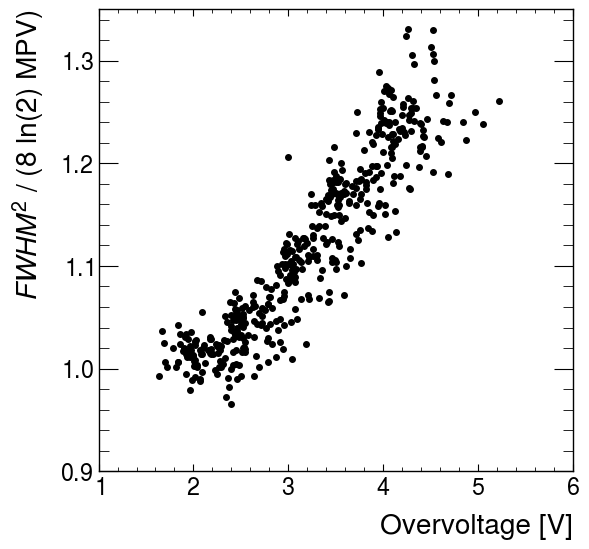

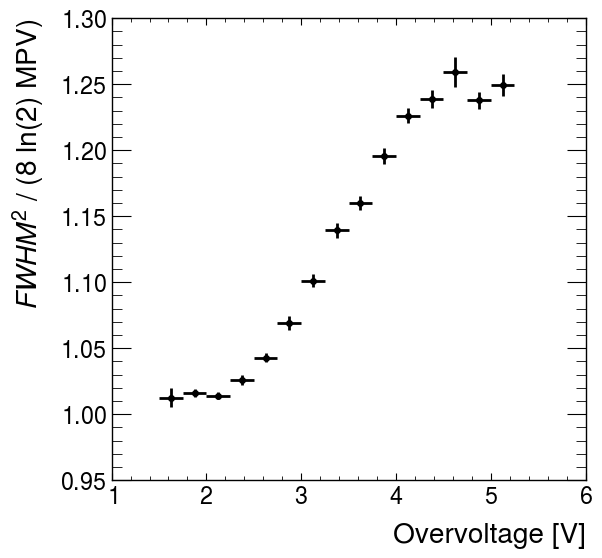

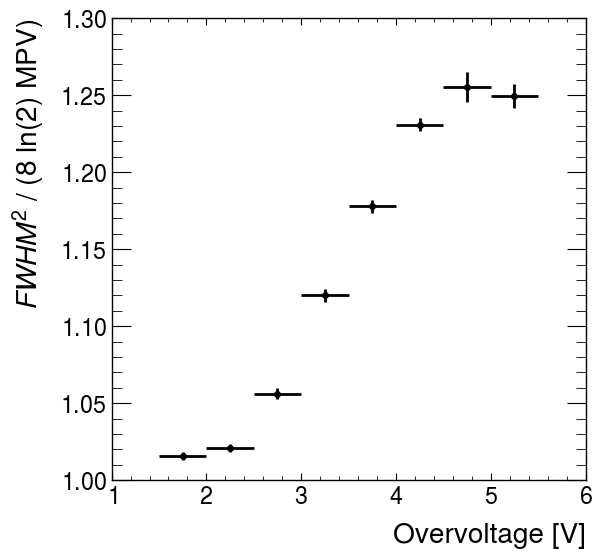

In [8]:
filepath_sidet = "/exp/mu2e/data/users/thoroho/sidet/"
filelist_sidet = ["{}{}{}".format(filepath_sidet, i, ":runSummary") for i in os.listdir(filepath_sidet)]

fig, ax0 = plt.subplots(1, 1)

Vover = []
crosstalk = []

for idx, filename in enumerate(filelist_sidet):
    FWHMratio = []
    PEratio = []
    temps = []
    chans = []
    histbins = np.linspace(0.25, 2, 30)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB",
                                report=False, library='ak'):
            for chan in range(16,64):
                if chan in badchannels:
                    continue
                Vbd = findVbd(filename, chan)
                if ar['PEsTemperatureCorrected'][0,0,chan] > 0 and ar['signals'][0,0,chan] > 4000:
                    ax0.errorbar(ar['biasVoltagesAvg'][0,0,chan%8] - Vbd, ((ar['FWHMs'][0,0,chan])**2)/(8*np.log(2)*ar['PEs'][0,0,chan]), yerr=0, color='k',fmt='.')                    
                    Vover.append(ar['biasVoltagesAvg'][0,0,chan%8] - Vbd)
                    crosstalk.append(((ar['FWHMs'][0,0,chan])**2)/(8*np.log(2)*ar['PEs'][0,0,chan]))
                    
#ax0.set_ylim((0.6, 1.4))
#ax0.set_xlim((-12,42))
ax0.set_xlabel('Overvoltage [V]')
ax0.set_ylabel('$FWHM^2$ / (8 ln(2) MPV)')

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()

fig, ax0 = plt.subplots(1, 1)
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='mean', bins=20, range=(1,6))
means = binned_stats[0]
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='std', bins=20, range=(1,6))
stddev = binned_stats[0]
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='count', bins=20, range=(1,6))
n = binned_stats[0]
stderror = np.divide(stddev, np.sqrt(n))

bin_centers = (binned_stats[1][:-1] + binned_stats[1][1:])/2
ax0.errorbar(x=bin_centers, y=means,yerr=stderror,xerr=0.125, color='k',fmt='.')
ax0.set_xlabel('Overvoltage [V]')
ax0.set_ylabel('$FWHM^2$ / (8 ln(2) MPV)')

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()
fig.show()

fig, ax0 = plt.subplots(1, 1)
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='mean', bins=10, range=(1,6))
means = binned_stats[0]
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='std', bins=10, range=(1,6))
stddev = binned_stats[0]
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='count', bins=10, range=(1,6))
n = binned_stats[0]
stderror = np.divide(stddev, np.sqrt(n))

bin_centers = (binned_stats[1][:-1] + binned_stats[1][1:])/2
ax0.errorbar(x=bin_centers, y=means,yerr=stderror,xerr=0.25, color='k',fmt='.')
ax0.set_xlabel('Overvoltage [V]')
ax0.set_ylabel('$FWHM^2$ / (8 ln(2) MPV)')

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()
fig.show()

In [9]:
biases = [51.7, 52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2]

def findBias(filename):
    runstring = ['1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916']
    for i, run in enumerate(runstring):
        if run in filename:
            bias = biases[i]
    return bias

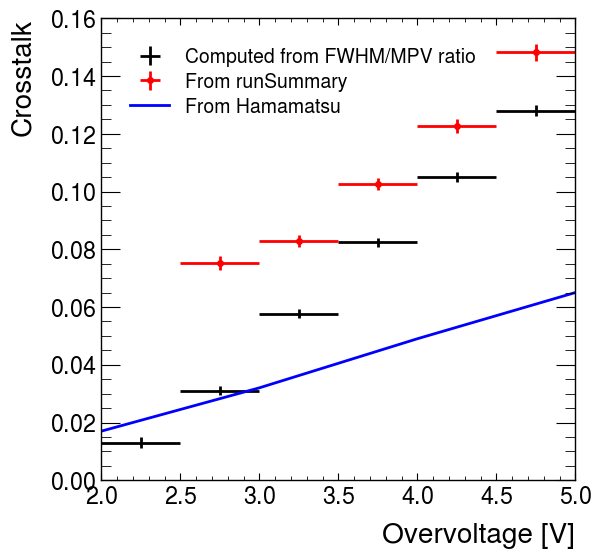

In [10]:
runs = [1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916]
processor = wideband.DataProcessor(usexroot=True, treename='runSummary', runlist=runs, userunlist=True, remove=False)
filelist_sidet = processor.getFilelist(DATASET)
filelist_sidet = ["{}{}".format(i, ":runSummary") for i in filelist_sidet]

def findVbd(filename, chan):
    Vbd = Vbd_channels[2][chan-16]
    return Vbd

Vover = []
Vover2 = []
ratio = []
crosstalk = []
Voverfromar = []
crosstalkfromar = []

for idx, filename in enumerate(filelist_sidet):
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB",
                                report=False, library='ak'):
            for chan in range(16,64):
                Vbd = findVbd(filename, chan)
                Vo = findBias(filename) - Vbd
                if ar['PEsTemperatureCorrected'][0,0,chan] > 0 and ar['signals'][0,0,chan] > 4000 and Vo >= 2 and Vo <= 5:
                    Vover.append(Vo)
                    ratio.append((ar['FWHMs'][0,0,chan])**2/(8*np.log(2)*ar['PEs'][0,0,chan]))
                    crosstalk.append(1 - math.sqrt((8*np.log(2)*ar['PEs'][0,0,chan])/(ar['FWHMs'][0,0,chan])**2))

                    if ar['xtalkProbability'][0,0,chan] > 0:
                        crosstalkfromar.append(ar['xtalkProbability'][0,0,chan])
                        Vover2.append(Vo)
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='mean', bins=6, range=(2,5))
means = binned_stats[0]
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='std', bins=6, range=(2,5))
stddev = binned_stats[0]
binned_stats = stats.binned_statistic(Vover, crosstalk, statistic='count', bins=6, range=(2,5))
n = binned_stats[0]
stderror = np.divide(stddev, np.sqrt(n))

binned_stats = stats.binned_statistic(Vover2, crosstalkfromar, statistic='mean', bins=6, range=(2,5))
meansfromar = binned_stats[0]
binned_stats = stats.binned_statistic(Vover2, crosstalkfromar, statistic='std', bins=6, range=(2,5))
stddevfromar = binned_stats[0]
binned_stats = stats.binned_statistic(Vover2, crosstalkfromar, statistic='count', bins=6, range=(2,5))
nfromar = binned_stats[0]
stderrorfromar = np.divide(stddevfromar, np.sqrt(nfromar))

bin_centers = (binned_stats[1][:-1] + binned_stats[1][1:])/2

Vo_hamamatsu = [2, 3, 4, 5, 6]
xtalk_hamamatsu = [0.017, 0.032, 0.049, 0.065, 0.082]

fig, ax0 = plt.subplots(1, 1)
ax0.errorbar(x=bin_centers, y=means, yerr=stderror, xerr=0.25, color='k', fmt='.', markersize=1, label='Computed from FWHM/MPV ratio')
ax0.errorbar(x=bin_centers, y=meansfromar,yerr=stderrorfromar,xerr=0.25, color='red',fmt='.',label='From runSummary')
ax0.errorbar(x=Vo_hamamatsu, y=xtalk_hamamatsu, color='blue', fmt='-', label='From Hamamatsu')
ax0.set_xlabel('Overvoltage [V]')
ax0.set_ylabel('Crosstalk')
ax0.set_ylim((0,0.16))
ax0.set_xlim((2,5))

ax0.legend()

fig.subplots_adjust(hspace=0)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.show()